In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = '../Datos/payment-attempts.csv'
pay_att = pd.read_csv(file_path)

# Make data frame of all payments

In [4]:
import json
from pandas import json_normalize

In [5]:
d = {} # dictionary to store the data and make the dataframe

# Iterate for each payment in the payments dataset
for i, p in pay_att.iterrows():
    pay_id = str(p['id']) # id of the payment
    val = p['value_msat']
    htlc_json = json.loads(p['htlcs'])
    # htlc data
    htlc_atts = json_normalize(htlc_json)
    # Iterate over the htlc data: each payment has multiple route attempts
    for ix, row in htlc_atts.iterrows():
        
        try:
            failed = row['failure.failure_source_index']
        except:
            failed = np.nan
        
        # the path succeeded?
        status = row['status']
        
        # Each route attempt has multiple hops
        hops = json_normalize(row['route.hops'])
        # Iterate over the hops: 
        for h_ix, h in hops.iterrows():
            chan_id = h['chan_id'] # get channel id
            p_key = h['pub_key'] # get public key
            try:
                fee_msat = h['fee_msat'] # get fee
            except:
                fee_msat = 0
            
            if failed == h_ix:
                d[(pay_id, ix, h_ix)] = [chan_id, p_key, fee_msat, True, status, pay_id]
            else:
                d[(pay_id, ix, h_ix)] = [chan_id, p_key, fee_msat, False, status, pay_id]

In [6]:
print(list(d.items())[0])

(('6577', 0, 0), [774770868577435649, '022eb09a7993a0edde69537b420f4119c0de833e0ee47651753b46bf884db75235', 25000.0, False, 2.0, '6577'])


In [7]:
# multiindex dataframe
payment_atts = pd.DataFrame(index=d.keys(), data=d.values())

In [8]:
payment_atts.columns = ['chan_id', 'pub_key', 'fee_msat', 'hop_fail', 'pay_status', 'pay_id']
payment_atts.index.set_names(['payment_id', 'attempt', 'hop'], inplace=True)

In [9]:
payment_atts.head(5)

chan_id  \
payment_id attempt hop                       
6577       0       0    774770868577435649   
                   1    818066337947451393   
                   2    806562147822862337   
                   3    791128303121137665   
           1       0    774770868577435649   

                                                                  pub_key  \
payment_id attempt hop                                                      
6577       0       0    022eb09a7993a0edde69537b420f4119c0de833e0ee476...   
                   1    038fe1bd966b5cb0545963490c631eaa1924e2c4c0ea4e...   
                   2    03d29a2fc370cf011a743d893de86ab9a920f2445539ea...   
                   3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...   
           1       0    022eb09a7993a0edde69537b420f4119c0de833e0ee476...   

                        fee_msat  hop_fail  pay_status pay_id  
payment_id attempt hop                                         
6577       0       0     25000.0     False         2.0   6577  
                   1         NaN     False         2.0   6577  
                   2         NaN     False         2.0   6577  
                   3         NaN      True         2.0   6577  
           1       0     25000.0     False         2.0   6577

### Add node alias to the data frame

In [10]:
def add_node_alias(df, nodes):
    """
    Add node alias to the dataframe
    """
    payment_df = df.copy()

    payment_df['node_alias'] = ''

    nodes_pubkeys = payment_df['pub_key'].unique()
    
    for i in nodes_pubkeys:
        
        for ix, j in nodes[['pub_key', 'alias']].iterrows():
            
            if i == j['pub_key']:
                payment_df.loc[payment_df['pub_key'] == i, 'node_alias'] = j['alias']

                break    
    return payment_df['node_alias']

In [11]:
# file_name = '../Datos/graph_metrics_2022-07-11.json'
# graph_data = open(file_name, encoding='utf8')
# graph_json = json.load(graph_data)
# # converting data to pd dfs
# nodes_graph = json_normalize(graph_json['nodes'])

In [12]:
# node_aliases = add_node_alias(payment_atts, nodes_graph)

In [13]:
# node_aliases.to_csv('node_aliases.csv', encoding='utf-8')

In [14]:
node_aliases = pd.read_csv('node_aliases.csv', index_col=[0,1,2])

In [15]:
idx = node_aliases.index
node_aliases.index = node_aliases.index.set_levels(idx.levels[0].astype(str), level=0)

In [16]:
payment_atts['node_alias'] = node_aliases

In [17]:
payment_atts

chan_id  \
payment_id attempt hop                       
6577       0       0    774770868577435649   
                   1    818066337947451393   
                   2    806562147822862337   
                   3    791128303121137665   
           1       0    774770868577435649   
...                                    ...   
6630       26      1    750057145744424961   
                   2    721103706067959809   
           27      0    778288206261059585   
                   1    816698545456480257   
                   2    817010806803070983   

                                                                  pub_key  \
payment_id attempt hop                                                      
6577       0       0    022eb09a7993a0edde69537b420f4119c0de833e0ee476...   
                   1    038fe1bd966b5cb0545963490c631eaa1924e2c4c0ea4e...   
                   2    03d29a2fc370cf011a743d893de86ab9a920f2445539ea...   
                   3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...   
           1       0    022eb09a7993a0edde69537b420f4119c0de833e0ee476...   
...                                                                   ...   
6630       26      1    02f6155b106a9f92a13738833ec7e25da58fab1fdef3ac...   
                   2    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...   
           27      0    036b53093df5a932deac828cca6d663472dbc88322b05e...   
                   1    02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5...   
                   2    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...   

                        fee_msat  hop_fail  pay_status pay_id  \
payment_id attempt hop                                          
6577       0       0     25000.0     False         2.0   6577   
                   1         NaN     False         2.0   6577   
                   2         NaN     False         2.0   6577   
                   3         NaN      True         2.0   6577   
           1       0     25000.0     False         2.0   6577   
...                          ...       ...         ...    ...   
6630       26      1     18628.0      True         2.0   6630   
                   2         NaN     False         2.0   6630   
           27      0     90998.0     False         2.0   6630   
                   1     20927.0      True         2.0   6630   
                   2         NaN     False         2.0   6630   

                                       node_alias  
payment_id attempt hop                             
6577       0       0             Ngu Technologies  
                   1       zero fee routing | CLN  
                   2                   ₿itcoin-⚡️  
                   3          WalletOfSatoshi.com  
           1       0             Ngu Technologies  
...                                           ...  
6630       26      1            VIVA La Lightning  
                   2          WalletOfSatoshi.com  
           27      0                       okcoin  
                   1    1sats.com ⚡ dm to connect  
                   2          WalletOfSatoshi.com  

[2908 rows x 7 columns]

In [18]:
payments_24 = payment_atts.loc[('6577'):'6601', :]

# Make suitable data frame for Altair

## Source and destination nodes

In [19]:
def add_source_and_dest(payment_df):
    """
    Create a new data frame with source and destination nodes as columns.
    """
    # creating the graph df:
    graph_df = pd.DataFrame(index=range(payment_df.shape[0]), 
                        columns=['source', 'destination'])
    
    # for setting sources and dests
    l =[]
    subl = []
    c = 0

    ixs = payment_df.index
    lenixs = len(ixs)

    for t in ixs[1:]:

        if ixs[c][0] != t[0]:
            l.append(subl.copy())
            subl.clear()

        subl.append(t[1])

        c += 1
        if c == lenixs - 1:
            l.append(subl.copy())
        
    ixs = [[max(e)] * (max(e) + 1)  for e in l]
    use = ixs[0]
    [use.extend(e) for e in ixs[1:]]
    
    # setting sources
    c = 1
    c2 =0
    graph_df.loc[0, 'source'] = 'LN_Capital'
    for i, hop in payment_df.iterrows():
        if c2 == len(use):break
        if i[1] != (use[c2]):
            graph_df.loc[c, 'source'] = hop['node_alias']
            c += 1
        else:
            c2+=1
            if c2 == len(use):break
            graph_df.loc[c, 'source'] = 'LN_Capital'
            c += 1
            c2-=1
            
        c2+=1
    
    # setting destinations
    c = 1
    c2 = 0
    first_dest = payment_df.loc[(0,0), 'node_alias']
    graph_df.iloc[0, 1] = first_dest
    for i, hop in payment_df.iterrows():
        if c2 == len(use):break
        if i[1] != (use[c2]):
            # dest
            
            graph_df.loc[c, 'destination'] = payment_df.loc[(i[0], i[1]+1), 'node_alias']
            c += 1
            
        else: 
            c2+=1
            if c2 == len(use):break
            graph_df.iloc[c, 1] = first_dest
            c += 1
            c2-=1
            
        c2+=1
    
    return graph_df #, routes_normalized

In [20]:
edges_list = add_source_and_dest(payments_24.loc[('6577')])
i= 0
for p_id, new_df in payments_24.loc[('6578'):,:].groupby(level=0):
    to_append_df = add_source_and_dest(new_df.droplevel(0))
    edges_list = pd.concat([edges_list, to_append_df])
    i+=1

In [21]:
edges_list.reset_index(drop=True, inplace=True)

## Position of the nodes

In [22]:
# get the indexes where the destination lies in
dest_ixs = edges_list[edges_list['destination'] == 'WalletOfSatoshi.com'].index.values

In [23]:
nodes_list = []
for i, node in enumerate(edges_list['source']):
    nodes_list.append(node)
    if i in dest_ixs:
        nodes_list.append('WalletOfSatoshi.com')

nodes_list = pd.DataFrame(nodes_list)

In [24]:
nodes_list[['X', 'Y']] =np.nan
# setting our node position to the origin
nodes_list.loc[0, ['X', 'Y']] = 0 
nodes_list.head(2)

,0,X,Y
0,LN_Capital,0.0,0.0
1,Ngu Technologies,NaN,NaN


### Algorithm to set the node position

In [25]:
pos = (0,0) # beginnig of the route (our nodes pos)
dest_found = False
dest_pos = None

update = 20

for ix, node in nodes_list.iterrows():
    
    all_pos = list(zip(nodes_list['X'], nodes_list['Y'])) # list of tuples - each tup is a coord
    
    if (nodes_list.loc[ix, ['X', 'Y']].isna().sum() == 2) and (node[0] != 'LN_Capital'):
#         if dest_found and node[0] == 'WalletOfSatoshi.com':
#             nodes_list.loc[ix, 'X'] = dest_pos[0]
#             nodes_list.loc[ix, 'Y'] = dest_pos[1]
#             pos = (0,0)
#             continue
        pos = (pos[0] + 100, pos[1]) # increasing x coord 
        
        while pos in all_pos: # if pos already taken, change coords until new pos 
            pos = (pos[0] - 50 - update, pos[1] + 50)
            if pos in all_pos:
                pos = (pos[0], pos[1] -100 - update)
                update += 20
        
        nodes_list.loc[nodes_list[0] == node[0], 'X'] = pos[0]
        nodes_list.loc[nodes_list[0] == node[0], 'Y'] = pos[1]
        
#         if node[0] == 'WalletOfSatoshi.com' and not dest_found:
#             print('coño')
#             dest_pos = copy.copy(pos)
#             dest_found=True
            
    else:
        # node is ours. Set pos to origin
        if node[0] == 'LN_Capital':
            nodes_list.loc[ix, ['X', 'Y']] = 0
            pos = (0,0)
        else:
            pos = (nodes_list.loc[ix, 'X'], nodes_list.loc[ix, 'Y'])

In [26]:
nodes_list.rename({0:'node_alias'}, axis=1, inplace=True)

In [27]:
import networkx as nx

In [28]:
# directed graph
g = nx.DiGraph()
# adding edges
for i, row in edges_list.iterrows():
    g.add_edge(row[0], row[1])

In [29]:
# adding position as a node attribute
for i, row in nodes_list.iterrows():
    g.nodes[row['node_alias']].update(row[1:].to_dict())

In [30]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], node[1]['Y']) for node in g.nodes(data=True)}

In [31]:
def show_graph_of_routes(g, node_positions, nodes_colors=None, widths=1, 
                         edges_colors='black', nodes_size=700, draw_fee_labels=False,
                         fee_labels=None):
    plt.figure(figsize=(20, 20))
    # drawing nodes
    nx.draw_networkx_nodes(g, pos=node_positions, node_size=nodes_size, 
                           node_color=nodes_colors, alpha=0.5,
                           )
    # drawing edges
    nx.draw_networkx_edges(
        g, pos=node_positions, 
        connectionstyle="arc3,rad=-0.1",  # curve the edges
        width=widths,
        edge_color=edges_colors,
#         edge_cmap=plt.cm.Reds
    )
    
    # labels
    nx.draw_networkx_labels(g, pos=node_positions, font_size=5, font_family="sans-serif",
                           font_color='purple', verticalalignment='top')
    if draw_fee_labels:
        nx.draw_networkx_edge_labels(g, pos=node_positions, edge_labels=fee_labels,
                                 font_size=4, label_pos=0.35)
    
    _ = plt.title('Graph Representation of the routes attempted trying to pay an invoice', size=15)

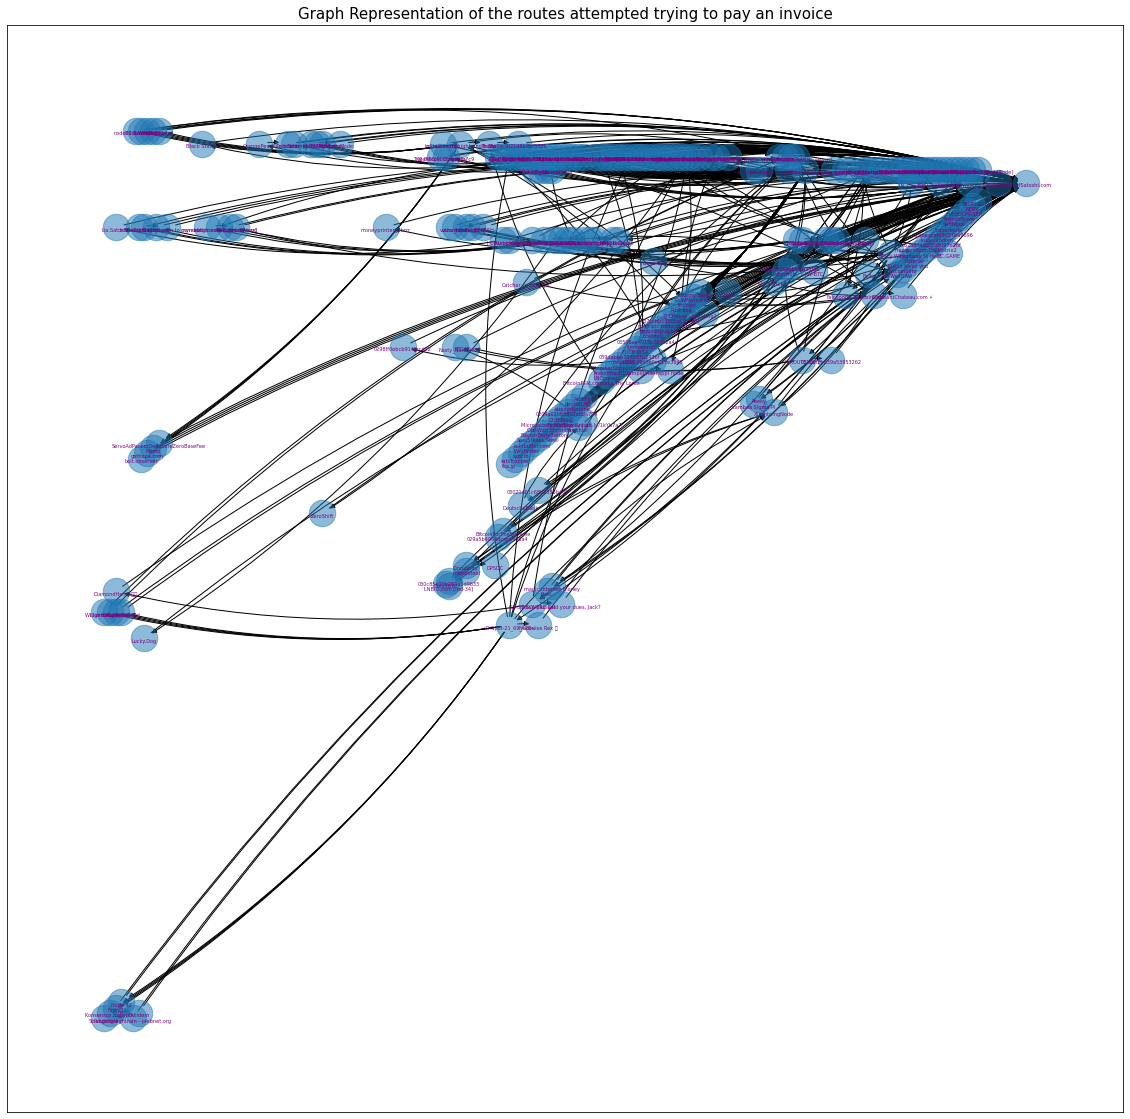

In [32]:

show_graph_of_routes(g, node_positions)

In [33]:
edges_list.head(2)

,source,destination
0,LN_Capital,Ngu Technologies
1,Ngu Technologies,zero fee routing | CLN


In [34]:
unique_nodes = nodes_list.drop_duplicates(subset=['node_alias'], keep='first')

In [35]:
# setting x1, x2, y1, y2 for source and destination nodes in edges_list from unique_nodes
for i, row in edges_list.iterrows():
    edges_list.loc[i, ['x1', 'y1']] = unique_nodes.loc[unique_nodes['node_alias'] == row['source'], ['X', 'Y']].values[0]
    edges_list.loc[i, ['x2','y2']] = unique_nodes.loc[unique_nodes['node_alias'] == row['destination'], ['X', 'Y']].values[0]
    

## Peers

In [36]:
edges_list['peers'] = list(zip(edges_list.source, edges_list.destination))

## Get size of the channel

In [37]:
edges_list['pay_id'] = [int(p_id) for p_id in payments_24['pay_id'].values]

In [38]:
edges_df = edges_list.groupby(['pay_id', 'peers'], sort=False).aggregate(
    {'source': 'size', 'pay_id': 'mean', 
    'x1': 'mean', 'y1': 'mean', 
    'x2': 'mean', 'y2': 'mean'}
)

In [39]:
edges_df.rename(columns={'source': 'size'}, inplace=True)
# duplicate size column and name in times_in_a_route 
edges_df['times_in_a_route'] = edges_df['size']

In [40]:
# add source and destination columns
edges_df['source'] = [s[0] for s in edges_df.index.get_level_values(1)]
edges_df['destination'] = [d[1] for d in edges_df.index.get_level_values(1)]

In [41]:
edges_df = edges_df.droplevel(0)

In [42]:
edges_df

,size,pay_id,x1,y1,x2,y2,times_in_a_route,source,destination
peers,,,,,,,,,
"(LN_Capital, Ngu Technologies)",9,6577.0,0.0,0.0,100.0,0.0,9,LN_Capital,Ngu Technologies
"(Ngu Technologies, zero fee routing | CLN)",9,6577.0,100.0,0.0,200.0,0.0,9,Ngu Technologies,zero fee routing | CLN
"(zero fee routing | CLN, ₿itcoin-⚡️)",1,6577.0,200.0,0.0,300.0,0.0,1,zero fee routing | CLN,₿itcoin-⚡️
"(₿itcoin-⚡️, WalletOfSatoshi.com)",1,6577.0,300.0,0.0,400.0,0.0,1,₿itcoin-⚡️,WalletOfSatoshi.com
"(zero fee routing | CLN, zero fee routing [TigerNode])",1,6577.0,200.0,0.0,230.0,50.0,1,zero fee routing | CLN,zero fee routing [TigerNode]
...,...,...,...,...,...,...,...,...,...
"(DonKingLN, WalletOfSatoshi.com)",1,6601.0,-1310.0,50.0,400.0,0.0,1,DonKingLN,WalletOfSatoshi.com
"(BCash_Is_Trash, CryptoShade)",1,6601.0,-130.0,50.0,-1020.0,-220.0,1,BCash_Is_Trash,CryptoShade
"(CryptoShade, WalletOfSatoshi.com)",1,6601.0,-1020.0,-220.0,400.0,0.0,1,CryptoShade,WalletOfSatoshi.com


## Get failures of the channels

In [43]:
edges_list['failures'] = payments_24['hop_fail'].values

In [44]:
edges_df['failures'] = edges_list.groupby(['pay_id', 'peers'], sort=False).aggregate({'failures': 'sum'}).droplevel(0)

## Get successes of the channels

In [45]:
edges_list['status'] = payments_24['pay_status'].values

In [46]:
edges_list.groupby(['pay_id', 'peers'], sort=False).aggregate({'status': 'mean'}).droplevel(0).isna().sum()
# some payments have no status (NaN)
# set those to 2 (failed)

status    12
dtype: int64

In [47]:
edges_df['status'] = edges_list.groupby(['pay_id', 'peers'], sort=False).aggregate({'status': 'mean'}).droplevel(0)

In [48]:
edges_df['status'].fillna(2, inplace=True)

## Color of the channels

In [49]:
edges_list['pay_id'] = [int(p_id) for p_id in payments_24['pay_id'].values]

In [50]:
# our node 
our_node = 'LN_Capital'
# destination node
dest_node = 'WalletOfSatoshi.com'

In [51]:
# set color: if size at current pair is less than or equal to the failures of previous pair, color blue, else keep the same color
# it already has

In [52]:
all_routes_df = edges_list.copy()
all_routes_df.set_index('peers', inplace=True)

In [53]:
all_routes_df

,source,destination,x1,y1,x2,y2,pay_id,failures,status
peers,,,,,,,,,
"(LN_Capital, Ngu Technologies)",LN_Capital,Ngu Technologies,0.0,0.0,100.0,0.0,6577,False,2.0
"(Ngu Technologies, zero fee routing | CLN)",Ngu Technologies,zero fee routing | CLN,100.0,0.0,200.0,0.0,6577,False,2.0
"(zero fee routing | CLN, ₿itcoin-⚡️)",zero fee routing | CLN,₿itcoin-⚡️,200.0,0.0,300.0,0.0,6577,False,2.0
"(₿itcoin-⚡️, WalletOfSatoshi.com)",₿itcoin-⚡️,WalletOfSatoshi.com,300.0,0.0,400.0,0.0,6577,True,2.0
"(LN_Capital, Ngu Technologies)",LN_Capital,Ngu Technologies,0.0,0.0,100.0,0.0,6577,False,2.0
...,...,...,...,...,...,...,...,...,...
"(LN_Capital, SWISS.SOVEREIGN)",LN_Capital,SWISS.SOVEREIGN,0.0,0.0,-1320.0,-1620.0,6601,False,2.0
"(SWISS.SOVEREIGN, HoernchenLightning)",SWISS.SOVEREIGN,HoernchenLightning,-1320.0,-1620.0,-780.0,100.0,6601,False,2.0
"(HoernchenLightning, BCash_Is_Trash)",HoernchenLightning,BCash_Is_Trash,-780.0,100.0,-130.0,50.0,6601,False,2.0


In [54]:
edges_df.reset_index(inplace=True)

In [55]:
all_routes_df['failures_count'] = 0
all_routes_df['size'] = 0


In [56]:
all_routes_df.reset_index(inplace=True)

In [57]:
peers_set = set()

In [58]:
for ix, row in all_routes_df.iterrows():
    if ix in peers_set:
        continue
    
    mask = (edges_df['source'] == row['source']) & (edges_df['destination'] == row['destination'])

    fails = edges_df.loc[(mask) & (edges_df['pay_id'] == row['pay_id']), 'failures']
    size = edges_df.loc[(mask) & (edges_df['pay_id'] == row['pay_id']), 'size']

    mask2 = (all_routes_df['source'] == row['source']) & (all_routes_df['destination'] == row['destination'])
    all_routes_df.loc[ix, 'failures_count'] = fails.values[0]
    all_routes_df.loc[ix, 'size'] = size.values[0]
    
    peers_set.add(ix)

In [59]:
all_routes_df.head(2)

,peers,source,destination,x1,y1,x2,y2,pay_id,failures,status,failures_count,size
0,"(LN_Capital, Ngu Technologies)",LN_Capital,Ngu Technologies,0.0,0.0,100.0,0.0,6577,False,2.0,0,9
1,"(Ngu Technologies, zero fee routing | CLN)",Ngu Technologies,zero fee routing | CLN,100.0,0.0,200.0,0.0,6577,False,2.0,0,9


In [60]:
all_routes_df.set_index('peers', inplace=True)

### Black and red channels

In [61]:
# set color based on failures. If failure is 0, color black, if failure is 1, color red
all_routes_df['color'] = all_routes_df['failures_count'].apply(lambda x: 'black' if x == 0 else 'red')

In [62]:
all_routes_df.head(3)

,source,destination,x1,y1,x2,y2,pay_id,failures,status,failures_count,size,color
peers,,,,,,,,,,,,
"(LN_Capital, Ngu Technologies)",LN_Capital,Ngu Technologies,0.0,0.0,100.0,0.0,6577,False,2.0,0,9,black
"(Ngu Technologies, zero fee routing | CLN)",Ngu Technologies,zero fee routing | CLN,100.0,0.0,200.0,0.0,6577,False,2.0,0,9,black
"(zero fee routing | CLN, ₿itcoin-⚡️)",zero fee routing | CLN,₿itcoin-⚡️,200.0,0.0,300.0,0.0,6577,False,2.0,0,1,black


In [63]:
all_routes_df = all_routes_df.set_index('pay_id', append=True).reorder_levels(['pay_id', 'peers'])

In [64]:
# our node 
our_node = 'LN_Capital'
# destination node
dest_node = 'WalletOfSatoshi.com'

In [65]:
all_routes_df

source  \
pay_id peers                                                                
6577   (LN_Capital, Ngu Technologies)                          LN_Capital   
       (Ngu Technologies, zero fee routing | CLN)        Ngu Technologies   
       (zero fee routing | CLN, ₿itcoin-⚡️)        zero fee routing | CLN   
       (₿itcoin-⚡️, WalletOfSatoshi.com)                       ₿itcoin-⚡️   
       (LN_Capital, Ngu Technologies)                          LN_Capital   
...                                                                   ...   
6601   (LN_Capital, SWISS.SOVEREIGN)                           LN_Capital   
       (SWISS.SOVEREIGN, HoernchenLightning)              SWISS.SOVEREIGN   
       (HoernchenLightning, BCash_Is_Trash)            HoernchenLightning   
       (BCash_Is_Trash, The Bitcoin Company)               BCash_Is_Trash   
       (The Bitcoin Company, WalletOfSatoshi.com)     The Bitcoin Company   

                                                              destination  \
pay_id peers                                                                
6577   (LN_Capital, Ngu Technologies)                    Ngu Technologies   
       (Ngu Technologies, zero fee routing | CLN)  zero fee routing | CLN   
       (zero fee routing | CLN, ₿itcoin-⚡️)                    ₿itcoin-⚡️   
       (₿itcoin-⚡️, WalletOfSatoshi.com)              WalletOfSatoshi.com   
       (LN_Capital, Ngu Technologies)                    Ngu Technologies   
...                                                                   ...   
6601   (LN_Capital, SWISS.SOVEREIGN)                      SWISS.SOVEREIGN   
       (SWISS.SOVEREIGN, HoernchenLightning)           HoernchenLightning   
       (HoernchenLightning, BCash_Is_Trash)                BCash_Is_Trash   
       (BCash_Is_Trash, The Bitcoin Company)          The Bitcoin Company   
       (The Bitcoin Company, WalletOfSatoshi.com)     WalletOfSatoshi.com   

                                                       x1      y1      x2  \
pay_id peers                                                                
6577   (LN_Capital, Ngu Technologies)                 0.0     0.0   100.0   
       (Ngu Technologies, zero fee routing | CLN)   100.0     0.0   200.0   
       (zero fee routing | CLN, ₿itcoin-⚡️)         200.0     0.0   300.0   
       (₿itcoin-⚡️, WalletOfSatoshi.com)            300.0     0.0   400.0   
       (LN_Capital, Ngu Technologies)                 0.0     0.0   100.0   
...                                                   ...     ...     ...   
6601   (LN_Capital, SWISS.SOVEREIGN)                  0.0     0.0 -1320.0   
       (SWISS.SOVEREIGN, HoernchenLightning)      -1320.0 -1620.0  -780.0   
       (HoernchenLightning, BCash_Is_Trash)        -780.0   100.0  -130.0   
       (BCash_Is_Trash, The Bitcoin Company)       -130.0    50.0 -1640.0   
       (The Bitcoin Company, WalletOfSatoshi.com) -1640.0   100.0   400.0   

                                                       y2  failures  status  \
pay_id peers                                                                  
6577   (LN_Capital, Ngu Technologies)                 0.0     False     2.0   
       (Ngu Technologies, zero fee routing | CLN)     0.0     False     2.0   
       (zero fee routing | CLN, ₿itcoin-⚡️)           0.0     False     2.0   
       (₿itcoin-⚡️, WalletOfSatoshi.com)              0.0      True     2.0   
       (LN_Capital, Ngu Technologies)                 0.0     False     2.0   
...                                                   ...       ...     ...   
6601   (LN_Capital, SWISS.SOVEREIGN)              -1620.0     False     2.0   
       (SWISS.SOVEREIGN, HoernchenLightning)        100.0     False     2.0   
       (HoernchenLightning, BCash_Is_Trash)          50.0     False     2.0   
       (BCash_Is_Trash, The Bitcoin Company)        100.0     False     2.0   
       (The Bitcoin Company, WalletOfSatoshi.com)     0.0      True     2.0   

                                 

### Black, red and blue channels

In [66]:
data = None

In [67]:
for p_id, pay_df in all_routes_df.groupby(level='pay_id'):
    
    pay_df['an_index'] = list(range(len(pay_df)))
    
    
    # break
    # df_ = pay_df.reset_index()
    
    pay_df['color'] = pay_df.apply(
        lambda row: 'blue' 
        if row.source != 'LN_Capital' and row['size'] <= pay_df.loc[pay_df['an_index'] == (row.an_index - 1), 'failures_count'].values 
        else row['color'], axis=1
    )
    # if 'blue' in pay_df['color'].values:
    #     more_blues = True
    # else:
    #     more_blues = False
    if data is None:
        data = pay_df
    else:
        data = data.append(pay_df)
    

In [68]:
data.reset_index(inplace=True)

In [69]:
for p_id, pay_row in data.reset_index().iterrows():

    # print(p_id)
    data.loc[p_id, 'color'] = 'blue' if pay_row.source != 'LN_Capital' and data.loc[p_id-1, 'color'] == 'blue' else pay_row['color']

    # pay_df['color'] = pay_df.apply(
    #     lambda row: 'blue'
    #     if row.an_index != 0 and pay_df.loc[pay_df['an_index'] == (row.an_index - 1), 'color'].values == 'blue'
    #     else row['color'], axis=1
    # )

    # if data2 is None:
    #     data2 = pay_df
    # else:
    #     data2 = data2.append(pay_df)


In [70]:
data[data['pay_id']==6584]

,pay_id,peers,source,destination,x1,y1,x2,y2,failures,status,failures_count,size,color,an_index
202,6584,"(LN_Capital, southxchange.com)",LN_Capital,southxchange.com,0.0,0.0,-370.0,50.0,False,2.0,0,25,black,0
203,6584,"(southxchange.com, WalletOfSatoshi.com)",southxchange.com,WalletOfSatoshi.com,-370.0,50.0,400.0,0.0,True,2.0,7,7,red,1
204,6584,"(LN_Capital, southxchange.com)",LN_Capital,southxchange.com,0.0,0.0,-370.0,50.0,False,2.0,0,25,black,2
205,6584,"(southxchange.com, Bitkoins.nl [c-lightning])",southxchange.com,Bitkoins.nl [c-lightning],-370.0,50.0,-740.0,100.0,True,2.0,6,6,red,3
206,6584,"(Bitkoins.nl [c-lightning], WalletOfSatoshi.com)",Bitkoins.nl [c-lightning],WalletOfSatoshi.com,-740.0,100.0,400.0,0.0,False,2.0,0,6,blue,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,6584,"(LN_Capital, southxchange.com)",LN_Capital,southxchange.com,0.0,0.0,-370.0,50.0,False,2.0,0,25,black,68
271,6584,"(southxchange.com, Dagnela 🦄 Hunter)",southxchange.com,Dagnela 🦄 Hunter,-370.0,50.0,-800.0,100.0,True,2.0,1,1,red,69
272,6584,"(Dagnela 🦄 Hunter, HoernchenLightning)",Dagnela 🦄 Hunter,HoernchenLightning,-800.0,100.0,-780.0,100.0,False,2.0,0,1,blue,70
273,6584,"(HoernchenLightning, Einundzwanzig)",HoernchenLightning,Einundzwanzig,-780.0,100.0,-680.0,100.0,False,2.0,0,2,blue,71


In [71]:
data = data.drop(columns=['an_index'])


In [72]:
# edges_df.drop(columns='index', inplace=True)

In [73]:
# set color from data to edges_df
for ix, row in edges_df.iterrows():
    masks = (data['source'] == row['source']) & (data['destination'] == row['destination']) & (data['pay_id'] == row['pay_id'])
    edges_df.loc[ix, 'color'] = data.loc[masks, 'color'].values[0]
    

In [74]:
edges_df.color.unique()

array(['black', 'red', 'blue'], dtype=object)

### Green channels for successful routes

In [75]:
# set color to green where status is 1
edges_df.loc[edges_df['status'] == 1, 'color'] = 'green'

In [76]:
edges_df[edges_df['status'] == 1]

,peers,size,pay_id,x1,y1,x2,y2,times_in_a_route,source,destination,failures,status,color
501,"(LN_Capital, southxchange.com)",2,6594.0,0.0,0.0,-370.0,50.0,2,LN_Capital,southxchange.com,0,1.0,green
502,"(southxchange.com, Ngu Technologies)",2,6594.0,-370.0,50.0,100.0,0.0,2,southxchange.com,Ngu Technologies,0,1.0,green
503,"(Ngu Technologies, WalletOfSatoshi.com)",2,6594.0,100.0,0.0,400.0,0.0,2,Ngu Technologies,WalletOfSatoshi.com,0,1.0,green
719,"(SWISS.SOVEREIGN, DiamondHands💎🙌)",1,6599.0,-1320.0,-1620.0,-2770.0,-1570.0,1,SWISS.SOVEREIGN,DiamondHands💎🙌,0,1.0,green
720,"(DiamondHands💎🙌, WalletOfSatoshi.com)",1,6599.0,-2770.0,-1570.0,400.0,0.0,1,DiamondHands💎🙌,WalletOfSatoshi.com,0,1.0,green
721,"(LN_Capital, SWISS.SOVEREIGN)",1,6600.0,0.0,0.0,-1320.0,-1620.0,1,LN_Capital,SWISS.SOVEREIGN,0,1.0,green
722,"(SWISS.SOVEREIGN, DiamondHands💎🙌)",1,6600.0,-1320.0,-1620.0,-2770.0,-1570.0,1,SWISS.SOVEREIGN,DiamondHands💎🙌,0,1.0,green
723,"(DiamondHands💎🙌, WalletOfSatoshi.com)",1,6600.0,-2770.0,-1570.0,400.0,0.0,1,DiamondHands💎🙌,WalletOfSatoshi.com,0,1.0,green


In [77]:
edges_df['pay_id'] = edges_df['pay_id'].astype('str')

In [78]:
# SET NODES COLOR
# LN_Capital -> yellow
# WalletOfSatoshi.com -> green
# the rest -> #1f77b4
edges_df['nodes_color'] = edges_df['source'].apply(lambda x: 'yellow' if x == our_node else 'green' if x == dest_node else '#1f77b4')

## Avg fee of the channels

In [113]:
all_routes_df['fee'] = payments_24['fee_msat'].values

In [120]:
all_routes_df

source  \
pay_id peers                                                                
6577   (LN_Capital, Ngu Technologies)                          LN_Capital   
       (Ngu Technologies, zero fee routing | CLN)        Ngu Technologies   
       (zero fee routing | CLN, ₿itcoin-⚡️)        zero fee routing | CLN   
       (₿itcoin-⚡️, WalletOfSatoshi.com)                       ₿itcoin-⚡️   
       (LN_Capital, Ngu Technologies)                          LN_Capital   
...                                                                   ...   
6601   (LN_Capital, SWISS.SOVEREIGN)                           LN_Capital   
       (SWISS.SOVEREIGN, HoernchenLightning)              SWISS.SOVEREIGN   
       (HoernchenLightning, BCash_Is_Trash)            HoernchenLightning   
       (BCash_Is_Trash, The Bitcoin Company)               BCash_Is_Trash   
       (The Bitcoin Company, WalletOfSatoshi.com)     The Bitcoin Company   

                                                              destination  \
pay_id peers                                                                
6577   (LN_Capital, Ngu Technologies)                    Ngu Technologies   
       (Ngu Technologies, zero fee routing | CLN)  zero fee routing | CLN   
       (zero fee routing | CLN, ₿itcoin-⚡️)                    ₿itcoin-⚡️   
       (₿itcoin-⚡️, WalletOfSatoshi.com)              WalletOfSatoshi.com   
       (LN_Capital, Ngu Technologies)                    Ngu Technologies   
...                                                                   ...   
6601   (LN_Capital, SWISS.SOVEREIGN)                      SWISS.SOVEREIGN   
       (SWISS.SOVEREIGN, HoernchenLightning)           HoernchenLightning   
       (HoernchenLightning, BCash_Is_Trash)                BCash_Is_Trash   
       (BCash_Is_Trash, The Bitcoin Company)          The Bitcoin Company   
       (The Bitcoin Company, WalletOfSatoshi.com)     WalletOfSatoshi.com   

                                                       x1      y1      x2  \
pay_id peers                                                                
6577   (LN_Capital, Ngu Technologies)                 0.0     0.0   100.0   
       (Ngu Technologies, zero fee routing | CLN)   100.0     0.0   200.0   
       (zero fee routing | CLN, ₿itcoin-⚡️)         200.0     0.0   300.0   
       (₿itcoin-⚡️, WalletOfSatoshi.com)            300.0     0.0   400.0   
       (LN_Capital, Ngu Technologies)                 0.0     0.0   100.0   
...                                                   ...     ...     ...   
6601   (LN_Capital, SWISS.SOVEREIGN)                  0.0     0.0 -1320.0   
       (SWISS.SOVEREIGN, HoernchenLightning)      -1320.0 -1620.0  -780.0   
       (HoernchenLightning, BCash_Is_Trash)        -780.0   100.0  -130.0   
       (BCash_Is_Trash, The Bitcoin Company)       -130.0    50.0 -1640.0   
       (The Bitcoin Company, WalletOfSatoshi.com) -1640.0   100.0   400.0   

                                                       y2  failures  status  \
pay_id peers                                                                  
6577   (LN_Capital, Ngu Technologies)                 0.0     False     2.0   
       (Ngu Technologies, zero fee routing | CLN)     0.0     False     2.0   
       (zero fee routing | CLN, ₿itcoin-⚡️)           0.0     False     2.0   
       (₿itcoin-⚡️, WalletOfSatoshi.com)              0.0      True     2.0   
       (LN_Capital, Ngu Technologies)                 0.0     False     2.0   
...                                                   ...       ...     ...   
6601   (LN_Capital, SWISS.SOVEREIGN)              -1620.0     False     2.0   
       (SWISS.SOVEREIGN, HoernchenLightning)        100.0     False     2.0   
       (HoernchenLightning, BCash_Is_Trash)          50.0     False     2.0   
       (BCash_Is_Trash, The Bitcoin Company)        100.0     False     2.0   
       (The Bitcoin Company, WalletOfSatoshi.com)     0.0      True     2.0   

                                 

In [126]:
fees = None

In [127]:
for p_id, pay_df in all_routes_df.groupby(level='pay_id'):
    # mask = edges_df['pay_id'] == p_id & edges_df['peers']
    group = pay_df.groupby(level='peers', sort=False)['fee'].aggregate(np.nanmean)
    # print(group)
    
    if fees is None:
        fees = group
    else:
        fees = fees.append(group)

In [131]:
fees.shape

(749,)

In [132]:
edges_df['avg_fee'] = fees.values

In [134]:
edges_df.fillna(0, inplace=True)

In [135]:
edges_df.head(2)

,peers,size,pay_id,x1,y1,x2,y2,times_in_a_route,source,destination,failures,status,color,nodes_color,avg_fee
0,"(LN_Capital, Ngu Technologies)",9,6577.0,0.0,0.0,100.0,0.0,9,LN_Capital,Ngu Technologies,0,2.0,black,yellow,25000.0
1,"(Ngu Technologies, zero fee routing | CLN)",9,6577.0,100.0,0.0,200.0,0.0,9,Ngu Technologies,zero fee routing | CLN,0,2.0,black,#1f77b4,0.0


# Visualize the payment attempts with Altair

In [79]:
import altair as alt

[Altair](https://altair-viz.github.io/index.html) is a data visualization tool for making interactive charts. An advantaje to other visualization libraries is that you can produce visualizations with a minimal amount of code. The hard work is done previously cleaning the data and transforming it into a format that Altair can understand.

Some main ideas to make an interactive visualization for the payment attempts:
- Menu to select the payments to visualize.
- Zoom in and out.
- Panning.
- Drag the pointer on top of a node to see the node alias, number of times it's been part of a route, and number of failures.
- Drag the pointer on top of a channel to see the average fee of the channel, number of times it's been part of a route, number of failures, and the number of times it's been part of a successful route.
- Filtering by dragging:
    - Brush to select a channels based on their payment activity.
    - Brush to select a nodes based on their payment activity.


In [80]:
# brush to select channels to be displayed based on the times in a route
edges_brush = alt.selection_interval(
    encodings=['x'],
)
# brush to select nodes to be displayed based on the times in a route
nodes_brush = alt.selection_interval(
    encodings=['x'],
)

In [81]:
# selection chart to filter the edges
channels_atts = alt.Chart(edges_df).mark_bar().add_selection(
    edges_brush
).encode(
    alt.X('sum_size:Q', title='Times a channel has been part of a route'),
    alt.Y('count():Q', title=None)
).transform_joinaggregate(
    groupby=['peers'], # group by peers so that size is the aggregate of all payments
    sum_size='sum(size)',
).properties(
    width=325,
    height=50
)
# selection chart to filter the nodes
nodes_atts = alt.Chart(edges_df).mark_bar().add_selection(
    nodes_brush
).encode(
    alt.X(
        'sum_size:Q', title='Times a node has been part of a route', 
        ), 
    alt.Y('count():Q', title=None, axis=alt.Axis(values=[20, 50, 100, 600]))
).transform_joinaggregate(
    groupby=['source'], # group by source to get nodes
    sum_size='sum(size)',
    # mean_size='mean(size)'
).properties(
    width=325,
    height=50
)

In [82]:
channels_atts

alt.Chart(...)

In [83]:
filter_by_attempts = channels_atts | nodes_atts

In [84]:
# Multiselection with a legend
ids = edges_df['pay_id'].unique()

In [85]:
ids_df = pd.DataFrame({'pay_id': ids})

In [86]:
multi_selection = alt.selection_multi(fields=['pay_id'])
color = alt.condition(
    multi_selection, alt.Color('pay_id:N'), alt.ColorValue('lightgray')
)
make_selector = alt.Chart(ids_df).mark_rect().encode(
    y='pay_id', color=color
).add_selection(
    multi_selection
)

In [87]:
make_selector

alt.Chart(...)

In [559]:
# Edges chart
edges_chart = alt.Chart(edges_df).mark_line().encode(
    x='x1', y='y1', x2='x2', y2='y2',
    tooltip=[
        alt.Tooltip('sum(times_in_a_route)', title='times in a route'), 
        alt.Tooltip('sum(failures)', title='failures'), 
        alt.Tooltip('peers', title='Channel'),
        alt.Tooltip('mean(avg_fee)', title='Avg fee msat'),
    ], 
    strokeWidth='sum(size)',
    color=alt.Color('color', scale=None), 
    opacity=alt.condition(edges_brush, alt.value(0.75), alt.value(0.05)),
).transform_joinaggregate(
    groupby=['peers'],
    mean_fee='mean(avg_fee)'
)   

In [560]:
# nodes chart
nodes_chart = alt.Chart(edges_df).mark_circle().encode(
    x='mean(x1)', y='mean(y1)', size=alt.Size('sum(size)', scale=alt.Scale(range=[100,1000])), 
    tooltip=[alt.Tooltip('source', title='node alias'), alt.Tooltip('sum(times_in_a_route)', title='times in a route')],
    color=alt.Color('nodes_color', scale=None),
    opacity=alt.condition(nodes_brush, alt.value(0.75), alt.value(0.05)),
).transform_joinaggregate(
    groupby=['source'],
    # sum_size='sum(size)',
    # mean_y='mean(y1)',
)

In [561]:
destination_node_df = pd.DataFrame(
    {'destination': [dest_node], 'size': [10], 'node_color': ['green'],
    'x': [400], 'y': [0]
    }
    )

In [562]:
destination_node_df

,destination,size,node_color,x,y
0,WalletOfSatoshi.com,10,green,400,0


In [563]:
destination_node_chart = alt.Chart(destination_node_df).mark_circle().encode(
    x='x', y='y', size=alt.Size('size', scale=alt.Scale(range=[100,1000])),
    tooltip=[alt.Tooltip('destination', title='node alias')],
    color=alt.Color('node_color', scale=None),
    opacity=alt.value(0.75)
)

In [564]:
edges_chart = edges_chart.transform_filter(multi_selection)
nodes_chart = nodes_chart.transform_filter(multi_selection)

In [565]:

chart = (
    (edges_chart
    + nodes_chart
    + destination_node_chart)
    ).encode(
        alt.X(axis=alt.Axis(labels=False, title=None)),
        alt.Y(axis=alt.Axis(labels=False, title=None)),
    ).properties(
    width=800,
    height=600
).interactive() # this is for zoom and pan

In [566]:
filter_by_attempts & (make_selector | chart)

alt.VConcatChart(...)

**New selector: expensive and often taken channels**

In [570]:
checkbox_selector = alt.selection_single(
    name='box_selector',
    fields=['avg_fee'],
    bind=alt.binding_checkbox(),
    init={'avg_fee': 'Any'},
    empty='all'
)

# color_cond = alt.condition(
#     "box_selector.avg_fee[0] == 'Any' || datum.avg_fee > 0",
#     # 'box_selector.datum.avg_fee > 0', 
#     alt.Color('color:N', scale=None), alt.ColorValue('lightgray')
# )

edges_chart = edges_chart.add_selection(
    checkbox_selector
).encode(
    opacity=alt.condition(checkbox_selector, alt.value(0.75), alt.value(0.05))
)

In [571]:
chart = (
    (edges_chart
    + nodes_chart
    + destination_node_chart)
    ).encode(
        alt.X(axis=alt.Axis(labels=False, title=None)),
        alt.Y(axis=alt.Axis(labels=False, title=None)),
    ).properties(
    width=800,
    height=600
).interactive() # this is for zoom and pan

In [572]:
filter_by_attempts & (make_selector | chart)

alt.VConcatChart(...)

In [574]:

df = pd.DataFrame({"Name": ['Tom','Dick','Harry'],
                   "Column_A": [1,2,3],
                   "Column_B": [10,20,30]})

column_select = alt.selection_single(fields=['column'],
                                     bind=alt.binding_select(options=['Column_A', 'Column_B'], name='column'),
                                     init={'column': 'Column_A'})

alt.Chart(df).mark_bar().transform_fold(
    fold=['Column_A', 'Column_B'],
    as_=['column', 'value']
).transform_filter(
    column_select
).encode(
    x='Name:N',
    color='value:Q',
).add_selection(
    column_select
)

alt.Chart(...)

In [106]:
data[(data['pay_id'] == 6584) & (data['source']=='Einundzwanzig')]

,pay_id,peers,source,destination,x1,y1,x2,y2,failures,status,failures_count,size,color
260,6584,"(Einundzwanzig, WalletOfSatoshi.com)",Einundzwanzig,WalletOfSatoshi.com,-680.0,100.0,400.0,0.0,False,2.0,0,2,black
274,6584,"(Einundzwanzig, WalletOfSatoshi.com)",Einundzwanzig,WalletOfSatoshi.com,-680.0,100.0,400.0,0.0,False,2.0,0,2,blue


In [95]:
full_chart = alt.vconcat(filter_by_attempts, (make_selector | chart)).properties(spacing=5).configure_view(strokeWidth=0
).configure_axis(grid=False)

In [96]:
filter_by_attempts

alt.HConcatChart(...)

In [97]:
full_chart

alt.VConcatChart(...)

In [98]:
edges_df[edges_df['pay_id']=='6584.0']

,peers,size,pay_id,x1,y1,x2,y2,times_in_a_route,source,destination,failures,status,color,nodes_color
126,"(LN_Capital, southxchange.com)",25,6584.0,0.0,0.0,-370.0,50.0,25,LN_Capital,southxchange.com,0,2.0,black,yellow
127,"(southxchange.com, WalletOfSatoshi.com)",7,6584.0,-370.0,50.0,400.0,0.0,7,southxchange.com,WalletOfSatoshi.com,7,2.0,red,#1f77b4
128,"(southxchange.com, Bitkoins.nl [c-lightning])",6,6584.0,-370.0,50.0,-740.0,100.0,6,southxchange.com,Bitkoins.nl [c-lightning],6,2.0,red,#1f77b4
129,"(Bitkoins.nl [c-lightning], WalletOfSatoshi.com)",6,6584.0,-740.0,100.0,400.0,0.0,6,Bitkoins.nl [c-lightning],WalletOfSatoshi.com,0,2.0,blue,#1f77b4
130,"(southxchange.com, cyberhub)",1,6584.0,-370.0,50.0,-440.0,-340.0,1,southxchange.com,cyberhub,1,2.0,red,#1f77b4
131,"(cyberhub, KW-BTC)",1,6584.0,-440.0,-340.0,-340.0,-340.0,1,cyberhub,KW-BTC,0,2.0,blue,#1f77b4
132,"(KW-BTC, WalletOfSatoshi.com)",1,6584.0,-340.0,-340.0,400.0,0.0,1,KW-BTC,WalletOfSatoshi.com,0,2.0,blue,#1f77b4
133,"(southxchange.com, Sunny Sarah ☀️)",1,6584.0,-370.0,50.0,-740.0,-420.0,1,southxchange.com,Sunny Sarah ☀️,1,2.0,red,#1f77b4
134,"(Sunny Sarah ☀️, Ginko)",1,6584.0,-740.0,-420.0,-640.0,-420.0,1,Sunny Sarah ☀️,Ginko,0,2.0,blue,#1f77b4
135,"(Ginko, WalletOfSatoshi.com)",1,6584.0,-640.0,-420.0,400.0,0.0,1,Ginko,WalletOfSatoshi.com,0,2.0,blue,#1f77b4


In [99]:
full_chart.save('payments_visualization.html')

In [100]:
# from altair_saver import save

In [101]:
# save(full_chart, 'chart.png')

# TODO:
- If a channel fails, just the next one colours in blue. If there are more channels after that, they are coloured in black.
- Add a checkbox to filter out all not successful payments, hence show only the successful ones.
- Add fee information to the channels, and update it when the filters are used.
- Full successful routes are not coloured in green. Only some channels are.

More things...
- Is there a way to curve the edges lines?
- Is there a way to put an arrow on the edges? To simulate a directed graph.